In [1]:
 #Imports
# ============================
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)


c:\Users\ARINDAM DAS\Desktop\spam trans\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Config
# ============================
MODEL_PATH = "./bert-spam"
TEST_CSV = "test.csv"
MAX_LENGTH = 256
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

label2id = {"Not Spam": 0, "Spam": 1}
id2label = {0: "Not Spam", 1: "Spam"}

In [3]:
# Load Model & Tokenizer
# ============================
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(DEVICE)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [4]:
# Load Test Dataset
# ============================
test_df = pd.read_csv(TEST_CSV)

In [5]:
# Expected columns:
# message -> email text
# label   -> "Spam" / "Not Spam"

test_df["label"] = test_df["label"].map(label2id)
test_df = test_df.dropna(subset=["message", "label"])

test_ds = Dataset.from_pandas(test_df, preserve_index=False)

In [6]:
# Tokenization
# ============================
def tokenize(batch):
    return tokenizer(
        batch["message"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )

test_ds = test_ds.map(tokenize, batched=True)
test_ds.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 10018/10018 [00:02<00:00, 4481.26 examples/s]


In [7]:
# Inference
# ============================
y_true = []
y_pred = []

with torch.no_grad():
    for sample in test_ds:
        input_ids = sample["input_ids"].unsqueeze(0).to(DEVICE)
        attention_mask = sample["attention_mask"].unsqueeze(0).to(DEVICE)
        label = sample["label"].item()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pred = outputs.logits.argmax(dim=-1).item()

        y_true.append(label)
        y_pred.append(pred)

In [8]:
# Metrics
# ============================
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, pos_label=1)
recall    = recall_score(y_true, y_pred, pos_label=1)
f1        = f1_score(y_true, y_pred, pos_label=1)

print("\n===== Test Set Metrics =====")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")



===== Test Set Metrics =====
Accuracy : 0.9929
Precision: 0.9927
Recall   : 0.9925
F1-score : 0.9926


In [9]:
print("\n===== Classification Report =====")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Not Spam", "Spam"],
        digits=4
    )
)


===== Classification Report =====
              precision    recall  f1-score   support

    Not Spam     0.9931    0.9933    0.9932      5237
        Spam     0.9927    0.9925    0.9926      4781

    accuracy                         0.9929     10018
   macro avg     0.9929    0.9929    0.9929     10018
weighted avg     0.9929    0.9929    0.9929     10018



In [10]:
# Confusion Matrix
# ============================
cm = confusion_matrix(y_true, y_pred)

print("\n===== Confusion Matrix =====")
print(cm)



===== Confusion Matrix =====
[[5202   35]
 [  36 4745]]


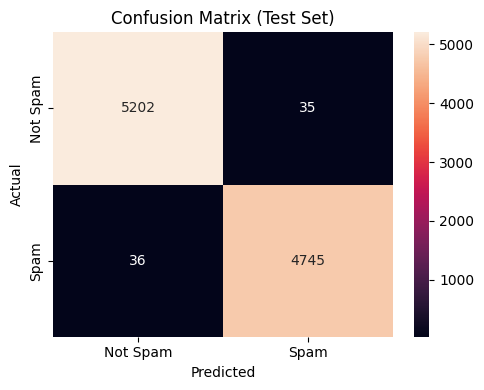

In [11]:
# Plot Confusion Matrix
# ============================
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["Not Spam", "Spam"],
    yticklabels=["Not Spam", "Spam"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


In [12]:
# Optional: save the plot
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>